In [31]:
# import kagglehub
# import shutil
# import os


# # Download latest version
# path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

# print("Path to dataset files:", path)

# # Create dataset directory if it doesn't exist
# dataset_dir = "./dataset"
# os.makedirs(dataset_dir, exist_ok=True)

# # Copy files from downloaded path to local dataset folder
# for item in os.listdir(path):
#     src_path = os.path.join(path, item)
#     dst_path = os.path.join(dataset_dir, item)
#     if os.path.isfile(src_path):
#         shutil.copy2(src_path, dst_path)
#     elif os.path.isdir(src_path):
#         shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

# print(f"Dataset files copied to: {dataset_dir}")


/home/dustinvan/WORK/Summer-2025-ECE-597-Group1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/dustinvan/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1
Dataset files copied to: ./dataset


In [1]:
import pandas as pd
import re

# Load phishing email dataset
phishing_df = pd.read_csv('./dataset/phishing_email.csv')

# traing split test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(phishing_df.text_combined,phishing_df.label, test_size=0.3, random_state=5)


In [2]:
def drop_dates(text):
    text = text.lower()
    # Remove URLs and email addresses
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' ', text)
    # match "Aug 08", "aug 8", "August 8th", "aug 2008", "2025-07-01", "12/25/24", etc.
    patterns = [
        r'\b(?:thu|wed|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{1,4}\b',
        r'\b\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4}\b',
        r'\b\d{4}\-[01]\d\-[0-3]\d\b',
        r'\b\d{1,4}\b'
    ]
    for p in patterns:
        text = re.sub(p, ' ', text, flags=re.IGNORECASE)
    return text


X_train_preprocessing = X_train.apply(drop_dates)
X_test_preprocessing = X_test.apply(drop_dates)

In [ ]:
#TF_IDF feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV

# Create a pipeline with TF-IDF and Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [100, 500, 1000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [2, 5, 10],
    'tfidf__max_df': [0.8, 0.9, 0.95],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Performing Grid Search with 5-fold Cross-Validation...")
grid_search.fit(X_train_preprocessing, y_train)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test_preprocessing)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix - Optimized TF-IDF + Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Performing Grid Search with 5-fold Cross-Validation...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [22]:
# Using bag of words approach
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline with CountVectorizer (Bag of Words) and Naive Bayes
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Define parameter grid for Bag of Words approach
bow_param_grid = {
    'vectorizer__max_features': [5000],
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__min_df': [5],
    'vectorizer__max_df': [0.8, 0.9],
    'classifier__alpha': [1.0, 2.0]
}

# Perform Grid Search with 5-fold cross-validation for Bag of Words
bow_grid_search = GridSearchCV(
    bow_pipeline, 
    bow_param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
print("Performing Grid Search with Bag of Words approach...")
bow_grid_search.fit(X_train_preprocessing, y_train)

# Print best parameters and score
print(f"\nBest BoW parameters: {bow_grid_search.best_params_}")
print(f"Best BoW cross-validation score: {bow_grid_search.best_score_:.4f}")

# Get the best model
best_bow_model = bow_grid_search.best_estimator_

# Make predictions on test set
y_pred_bow = best_bow_model.predict(X_test_preprocessing)

# Calculate accuracy
bow_accuracy = accuracy_score(y_test, y_pred_bow)
print(f"\nBag of Words Test Set Accuracy: {bow_accuracy:.4f}")

# Print detailed classification report
print("\nBag of Words Classification Report:")
print(classification_report(y_test, y_pred_bow))

# Create confusion matrix for Bag of Words
plt.figure(figsize=(8, 6))
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix - Bag of Words + Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1529673170.py, line 21)

In [ ]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
# Encode the text
from tqdm import tqdm
tqdm.pandas()

import os

if os.path.exists('X_train_encoded.csv') and os.path.exists('X_test_encoded.csv'):
    print("Loading encoded training data from CSV...")
    X_train_preprocessing = pd.read_csv('X_train_encoded.csv')
    print("Loading encoded test data from CSV...")
    X_test_preprocessing = pd.read_csv('X_test_encoded.csv')

else:
    print("Encoded CSV files not found. Encoding text...")
    # Encode the text
    print("Encoding training data...")
    X_train_encoded = X_train_preprocessing.progress_apply(lambda x: model.encode(x))
    print("Encoding test data...")
    X_test_preprocessing['encoded_text'] = X_test_preprocessing.progress_apply(lambda x: model.encode(x))
    print("Encoding complete!")
    
    # Save encoded data to CSV files
    print("Saving encoded training data to CSV...")
    X_train_preprocessing.to_csv('X_train_encoded.csv', index=False)
    print("Saving encoded test data to CSV...")
    X_test_preprocessing.to_csv('X_test_encoded.csv', index=False)
    print("CSV files saved!")

Loading encoded training data from CSV...
Loading encoded test data from CSV...
                                       text_combined
0  specia alert investors mnei best smal cap stoc...
1  biographies linguists dear colleagues compile ...
2  chief anthony enahoro jp coalition_protectyaho...
3  garey christopher cherryvectorbdcom looking ch...
4  annie ibarra annieblastmyresumecom dont let sm...


In [20]:
X_train_preprocessing[0:10].progress_apply(lambda x: model.encode(x))

100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


71320    [0.032716207, 0.04215074, 0.0056662275, 0.0161...
45008    [0.026764162, 0.0381513, -0.00087995693, -0.01...
40776    [-0.03438361, 0.068594374, 0.0028300332, 0.007...
73073    [0.009313267, -0.03904837, -0.037746947, 0.023...
74912    [0.026984882, 0.119919226, -0.013650567, 5.451...
75378    [-0.022969645, 0.06328497, -0.019607529, -0.03...
66181    [-0.028571837, -0.03333826, -0.03873318, -0.03...
9432     [0.06978806, 0.017235484, -0.044627044, -0.011...
41263    [0.049832392, 9.091576e-05, 0.0034231476, -0.0...
39335    [0.063354805, 0.013418837, 0.004483959, -0.043...
Name: text_combined, dtype: object

In [14]:


# Apply PCA to reduce dimensionality of encoded text
from sklearn.decomposition import PCA
import numpy as np

# Convert encoded text to arrays for PCA
X_train_encoded = np.array(X_train_preprocessing['text_combined'].tolist())
X_test_encoded = np.array(X_test_preprocessing['text_combined'].tolist())

# Initialize PCA (reduce to 100 components, adjust as needed)
pca = PCA(n_components=100, random_state=42)

# Fit PCA on training data and transform both train and test
X_train_pca = pca.fit_transform(X_train_encoded)
X_test_pca = pca.transform(X_test_encoded)

print(f"Original encoding shape: {X_train_encoded.shape}")
print(f"PCA reduced shape: {X_train_pca.shape}")
print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")


# Train Logistic Regression with encoded features
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_pca, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_pca)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy with Sentence Transformers: {accuracy_lr:.4f}")

# Print detailed classification report
print("\nClassification Report - Logistic Regression with Sentence Transformers:")
print(classification_report(y_test, y_pred_lr))

# Create confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix - Sentence Transformers + Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()





MemoryError: Unable to allocate 187. GiB for an array with shape (57739,) and data type <U868287

In [30]:
enron_df = enron_df.sample(n=10, random_state=42)

def getbody(text):
    text = str(text).lower()
    # Remove email headers (basic cleaning)
    text = re.sub(r'^(from|to|subject|date|cc|bcc):[^\n]*\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    info = text.split('\n\n')
    print(" ".join(info[1:]))
    return " ".join(info[1:])
    

enron_df['body'] = enron_df['message'].apply(getbody)

# Count domains, links, and phone numbers in the email
def count_domains(text):
    """Count number of unique domains in email"""
    if pd.isna(text):
        return 0
    text = str(text)
    # Pattern to match domains (basic pattern)
    domain_pattern = r'@([a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'
    domains = re.findall(domain_pattern, text)
    return len(set(domains))  # Return unique domains

def count_links(text):
    """Count number of links/URLs in email"""
    if pd.isna(text):
        return 0
    text = str(text)
    # Pattern to match URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    links = re.findall(url_pattern, text)
    return len(links)

def count_phones(text):
    """Count number of phone numbers in email"""
    if pd.isna(text):
        return 0
    text = str(text)
    # Pattern to match phone numbers (various formats)
    phone_patterns = [
        r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b',  # 123-456-7890 or 123.456.7890 or 1234567890
        r'\(\d{3}\)\s*\d{3}[-.]?\d{4}',   # (123) 456-7890
        r'\+\d{1,3}[-.\s]?\d{3}[-.\s]?\d{3}[-.\s]?\d{4}',  # +1-123-456-7890
        r'\b\d{10}\b'  # 10 digit number
    ]
    
    phone_count = 0
    for pattern in phone_patterns:
        phones = re.findall(pattern, text)
        phone_count += len(phones)
    
    return phone_count

# Apply counting functions to the sample
enron_df['domain_count'] = enron_df['message'].apply(count_domains)
enron_df['link_count'] = enron_df['message'].apply(count_links)
enron_df['phone_count'] = enron_df['message'].apply(count_phones)

print("Analysis of Enron emails (sample):")
print(f"Total domains found: {enron_df['domain_count'].sum()}")
print(f"Total links found: {enron_df['link_count'].sum()}")
print(f"Total phone numbers found: {enron_df['phone_count'].sum()}")
print(f"Average domains per email: {enron_df['domain_count'].mean():.2f}")
print(f"Average links per email: {enron_df['link_count'].mean():.2f}")
print(f"Average phone numbers per email: {enron_df['phone_count'].mean():.2f}")

print("\nDetailed breakdown:")
print(enron_df[['domain_count', 'link_count', 'phone_count']].describe())






bill:  thanks for the info.   i also spoke with jeff about how 
enroncredit.com ltd. was going to work since dennis o'connell (london lawyer) 
is responsible for that group.  maybe you will be able to clarify which of 
jeff's "positions" will be hedges and which will be backed to enroncredit.  
maybe rod will be handling most of jeff's credit.  i'd appreciate an update.  
sara  	william s bradford
	08/29/2000 07:24 am
		
		 to: sara shackleton/hou/ect@ect
		 cc: mark taylor/hou/ect@ect, paul radous/corp/enron@enron, rod 
nelson/lon/ect@ect
		 subject: re: credit derivatives sara, please contact either paul radous or me on credit derivatives in the u.s.  
rod nelson is the lead credit support for enroncredit.com and should also be 
available in london, if necessary.  i am not aware of these recent trades but 
i am having lunch with jeff kinneman on thursday to discuss among other 
things credit support for his business.   it does concern me that we would offer to provide collateral dlj 

In [ ]:
# Clean and preprocess text for TF-IDF
def clean_text_for_tfidf(text):
    """Clean text for TF-IDF analysis"""
    if pd.isna(text):
        return ""
    # Convert to string and lowercase
    text = str(text).lower()
    # Remove email headers (basic cleaning)
    text = re.sub(r'^(from|to|subject|date|cc|bcc):[^\n]*\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning
# Reduce dataset size to 10k samples
enron_df['body'] = enron_df['message'].apply(clean_text_for_tfidf)

# Standardize column names - UVic dataset has 'Subject' and 'Body', Enron has 'subject' and 'body'
uvic_df = uvic_df.rename(columns={'Subject': 'subject', 'Body': 'body'})
uvic_df['body'] = uvic_df['body'].str.replace('Notice: This message was sent from outside the University of Victoria email system. Please be cautious with links and sensitive information.', '').str.strip()
uvic_df['body'] = uvic_df['body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)


# Add label column to datasets if not present
# Assuming Enron emails are legitimate (label=0) and UVic emails are phishing (label=1)
if 'label' not in enron_df.columns:
    enron_df['label'] = 0
if 'label' not in uvic_df.columns:
    uvic_df['label'] = 1

# Display basic info about the datasets
print("Enron dataset shape:", enron_df.shape)
print("UVic dataset shape:", uvic_df.shape)
print("\nEnron columns:", enron_df.columns.tolist())
print("UVic columns:", uvic_df.columns.tolist())

Enron dataset shape: (2000, 4)
UVic dataset shape: (2000, 5)

Enron columns: ['file', 'message', 'body', 'label']
UVic columns: ['subject', 'body', 'Unnamed: 2', 'Unnamed: 3', 'label']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Select only the columns we need and combine the datasets
enron_clean = enron_df[['body', 'label']].copy()
uvic_df['body'] = uvic_df['body'].str.replace('Notice: This message was sent from outside the University of Victoria email system. Please be cautious with links and sensitive information.', '').str.strip()
uvic_df['body'] = uvic_df['body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

uvic_clean = uvic_df[['subject', 'body', 'label']].copy()

df = pd.concat([enron_clean, uvic_clean], ignore_index=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Non-phishing emails (label=0): {len(df[df['label'] == 0])}")
print(f"Phishing emails (label=1): {len(df[df['label'] == 1])}")


# Combine subject and body for full text analysis
df['full_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')

# Separate phishing (label=1) and non-phishing (label=0) emails
phishing_emails = df[df['label'] == 1]['full_text'].tolist()
non_phishing_emails = df[df['label'] == 0]['full_text'].tolist()

print(f"Number of phishing emails: {len(phishing_emails)}")
print(f"Number of non-phishing emails: {len(non_phishing_emails)}")

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100000,  # Limit to top 5000 features
    stop_words='english',  # Remove common English stop words
    lowercase=True,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Fit TF-IDF on all emails and transform
all_emails = phishing_emails + non_phishing_emails
tfidf_matrix = tfidf_vectorizer.fit_transform(all_emails)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Split the TF-IDF matrix back into phishing and non-phishing
phishing_tfidf = tfidf_matrix[:len(phishing_emails)]
non_phishing_tfidf = tfidf_matrix[len(phishing_emails):]

# Calculate mean TF-IDF scores for each class
phishing_mean_tfidf = np.array(phishing_tfidf.mean(axis=0)).flatten()
non_phishing_mean_tfidf = np.array(non_phishing_tfidf.mean(axis=0)).flatten()

# Create DataFrames for analysis
phishing_tfidf_df = pd.DataFrame({
    'word': feature_names,
    'tfidf_score': phishing_mean_tfidf
}).sort_values('tfidf_score', ascending=False)

non_phishing_tfidf_df = pd.DataFrame({
    'word': feature_names,
    'tfidf_score': non_phishing_mean_tfidf
}).sort_values('tfidf_score', ascending=False)

print("\nTop 20 TF-IDF words in PHISHING emails:")
print(phishing_tfidf_df.head(20))

print("\nTop 20 TF-IDF words in NON-PHISHING emails:")
print(non_phishing_tfidf_df.head(20))

# Calculate the difference in TF-IDF scores
tfidf_diff_df = pd.DataFrame({
    'word': feature_names,
    'phishing_tfidf': phishing_mean_tfidf,
    'non_phishing_tfidf': non_phishing_mean_tfidf,
    'difference': phishing_mean_tfidf - non_phishing_mean_tfidf
})

Combined dataset shape: (4000, 3)
Label distribution:
label
0    2000
1    2000
Name: count, dtype: int64
Non-phishing emails (label=0): 2000
Phishing emails (label=1): 2000
Number of phishing emails: 2000
Number of non-phishing emails: 2000

Top 20 TF-IDF words in PHISHING emails:
           word  tfidf_score
15577      uvic     0.070213
2396         ca     0.060103
5109      email     0.042070
557     account     0.036181
124        2022     0.033770
7008   helpdesk     0.026400
7006      hello     0.024884
15494    update     0.023114
9178       mail     0.021871
10992  password     0.020508
9180    mailbox     0.020243
4024       dear     0.020138
12531     reply     0.019830
11042   payment     0.018628
651     address     0.017323
13387      sent     0.015899
2994      click     0.015772
12361   regards     0.015738
13421   service     0.015552
4303    details     0.015475

Top 20 TF-IDF words in NON-PHISHING emails:
             word  tfidf_score
3042           cn     0.070256
3

In [8]:

print("\nWords most characteristic of PHISHING emails (highest positive difference):")
phishing_characteristic_words = tfidf_diff_df.sort_values('difference', ascending=False).head(100)
print(phishing_characteristic_words)

print("\nWords most characteristic of NON-PHISHING emails (highest negative difference):")
non_phishing_characteristic_words = tfidf_diff_df.sort_values('difference', ascending=True).head(100)
print(non_phishing_characteristic_words)

# Extract top characteristic words for each class to use as features
top_phishing_words = phishing_characteristic_words['word'].tolist()
top_non_phishing_words = non_phishing_characteristic_words['word'].tolist()

# Combine the top characteristic words from both classes
characteristic_words_features = top_phishing_words + top_non_phishing_words

print(f"\nUsing {len(characteristic_words_features)} characteristic words as features:")
print(f"Top phishing words: {top_phishing_words[:10]}...")
print(f"Top non-phishing words: {top_non_phishing_words[:10]}...")

# Create a new TF-IDF vectorizer using only characteristic words as features
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([enron_clean, uvic_clean], ignore_index=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Non-phishing emails (label=0): {len(df[df['label'] == 0])}")
print(f"Phishing emails (label=1): {len(df[df['label'] == 1])}")


# Combine subject and body for full text analysis
df['full_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')

# Separate phishing (label=1) and non-phishing (label=0) emails
phishing_emails = df[df['label'] == 1]['full_text'].tolist()
non_phishing_emails = df[df['label'] == 0]['full_text'].tolist()
all_emails = phishing_emails + non_phishing_emails

# Create vectorizer with characteristic words as vocabulary
characteristic_tfidf = TfidfVectorizer(
    vocabulary=characteristic_words_features,
    stop_words='english',
    max_features=len(characteristic_words_features)
)

# Transform emails using characteristic words only
characteristic_tfidf_matrix = characteristic_tfidf.fit_transform(all_emails)

print(f"Characteristic words TF-IDF matrix shape: {characteristic_tfidf_matrix.shape}")
print(f"Using {len(characteristic_words_features)} characteristic words as features")


Words most characteristic of PHISHING emails (highest positive difference):
               word  phishing_tfidf  non_phishing_tfidf  difference
15577          uvic        0.070213            0.000000    0.070213
2396             ca        0.060103            0.001171    0.058932
5109          email        0.042070            0.005665    0.036405
557         account        0.036181            0.001333    0.034848
124            2022        0.033770            0.000000    0.033770
...             ...             ...                 ...         ...
563        accounts        0.006324            0.000571    0.005753
156              24        0.005702            0.000000    0.005702
13491        shared        0.005681            0.000148    0.005533
14331  subscription        0.006030            0.000527    0.005503
15742          view        0.007071            0.001726    0.005344

[100 rows x 4 columns]

Words most characteristic of NON-PHISHING emails (highest negative difference):
  

Original dataset - Phishing: 2000, Non-phishing: 2000
Balanced dataset - Phishing: 2000, Non-phishing: 2000
Training set size: 2800 samples
Testing set size: 1200 samples
Number of features: 200

Naive Bayes Classifier Accuracy: 0.9700

Classification Report:
              precision    recall  f1-score   support

Non-Phishing       0.95      1.00      0.97       600
    Phishing       1.00      0.94      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



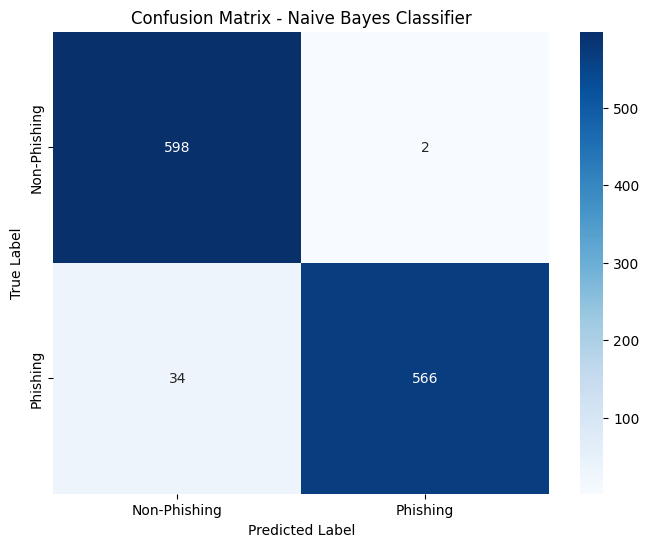


Top 20 most important words for PHISHING classification:
                                word  importance
0                               uvic    5.608302
4                               2022    4.987757
5                           helpdesk    4.116975
33                             gmail    3.939939
15                          victoria    3.899437
1                                 ca    3.850955
25                              spam    3.848612
63                               000    3.844423
46                                00    3.833729
66                                43    3.789927
28                         suspected    3.767694
55  ________________________________    3.696218
77                                12    3.573705
23                            kindly    3.530665
6                              hello    3.480053
73                                11    3.477640
64                                10    3.473286
47                          incoming    3.404127
8          

In [10]:
# Naive Bayes Classification using TF-IDF features
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for classification
X = characteristic_tfidf_matrix.toarray()  # Convert sparse matrix to dense array
y = np.array([1] * len(phishing_emails) + [0] * len(non_phishing_emails))  # 1 for phishing, 0 for non-phishing

# Check class distribution before balancing
print(f"Original dataset - Phishing: {sum(y)}, Non-phishing: {len(y) - sum(y)}")

# Apply undersampling to balance the dataset
from sklearn.utils import resample

# Combine X and y for easier manipulation
X_with_labels = np.column_stack((X, y))

# Separate phishing and non-phishing samples
phishing_samples = X_with_labels[X_with_labels[:, -1] == 1]
non_phishing_samples = X_with_labels[X_with_labels[:, -1] == 0]

# Determine the minority class size
min_class_size = min(len(phishing_samples), len(non_phishing_samples))

# Undersample the majority class to match the minority class size
phishing_balanced = resample(phishing_samples, 
                           replace=False, 
                           n_samples=min_class_size, 
                           random_state=42)
non_phishing_balanced = resample(non_phishing_samples, 
                               replace=False, 
                               n_samples=min_class_size, 
                               random_state=42)

# Combine the balanced datasets
balanced_data = np.vstack((phishing_balanced, non_phishing_balanced))

# Shuffle the balanced dataset
np.random.seed(42)
np.random.shuffle(balanced_data)

# Separate features and labels
X_balanced = balanced_data[:, :-1]
y_balanced = balanced_data[:, -1].astype(int)

print(f"Balanced dataset - Phishing: {sum(y_balanced)}, Non-phishing: {len(y_balanced) - sum(y_balanced)}")

# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, stratify=y_balanced)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Initialize and train the Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=1.0)  # alpha is the Laplace smoothing parameter
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nNaive Bayes Classifier Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Phishing', 'Phishing']))

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Phishing', 'Phishing'],
            yticklabels=['Non-Phishing', 'Phishing'])
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get feature importance (log probabilities)
feature_log_prob = nb_classifier.feature_log_prob_
feature_importance_phishing = feature_log_prob[1] - feature_log_prob[0]  # Difference between phishing and non-phishing

# Get feature names from the vectorizer
feature_names = characteristic_tfidf.get_feature_names_out()

# Create DataFrame for feature importance analysis
feature_importance_df = pd.DataFrame({
    'word': feature_names,
    'importance': feature_importance_phishing
}).sort_values('importance', ascending=False)

print("\nTop 20 most important words for PHISHING classification:")
print(feature_importance_df.head(20))

print("\nTop 20 most important words for NON-PHISHING classification:")
print(feature_importance_df.tail(20))

# Predict probabilities for some test examples
test_probabilities = nb_classifier.predict_proba(X_test)
print(f"\nSample predictions with probabilities:")
for i in range(min(10, len(X_test))):
    pred_label = "Phishing" if y_pred[i] == 1 else "Non-Phishing"
    true_label = "Phishing" if y_test[i] == 1 else "Non-Phishing"
    prob_phishing = test_probabilities[i][1]
    print(f"Sample {i+1}: Predicted={pred_label}, True={true_label}, P(Phishing)={prob_phishing:.4f}")


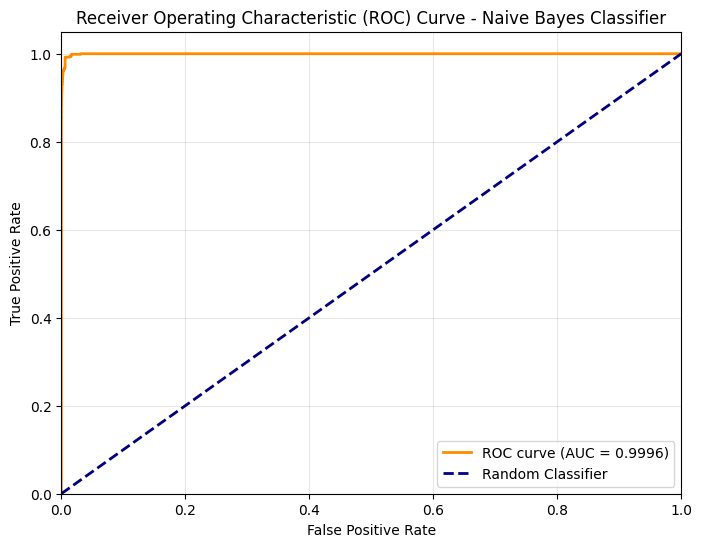

Area Under the ROC Curve (AUC): 0.9996


In [11]:
# Plot ROC (Receiver Operating Characteristic) curve
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for ROC curve
y_proba = nb_classifier.predict_proba(X_test)[:, 1]  # Probability of positive class (phishing)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.4f}")


In [21]:
enron_df = pd.read_csv('../dataset/emails.csv')
uvic_df = pd.read_csv('../dataset/CaptstoneProjectData_2025.csv')


# Apply text cleaning
# Reduce dataset size to 10k samples
enron_df['body'] = enron_df['message'].apply(clean_text_for_tfidf)

# Standardize column names - UVic dataset has 'Subject' and 'Body', Enron has 'subject' and 'body'
uvic_df = uvic_df.rename(columns={'Subject': 'subject', 'Body': 'body'})
uvic_df['body'] = uvic_df['body'].str.replace('Notice: This message was sent from outside the University of Victoria email system. Please be cautious with links and sensitive information.', '').str.strip()
uvic_df['body'] = uvic_df['body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)


# Add label column to datasets if not present
# Assuming Enron emails are legitimate (label=0) and UVic emails are phishing (label=1)
if 'label' not in enron_df.columns:
    enron_df['label'] = 0
if 'label' not in uvic_df.columns:
    uvic_df['label'] = 1


# Combine subject and body for full text analysis
df['full_text'] =  df['body'].fillna('')

# Separate phishing (label=1) and non-phishing (label=0) emails
phishing_emails = df[df['label'] == 1]['full_text'].tolist()
non_phishing_emails = df[df['label'] == 0]['full_text'].tolist()
all_emails = phishing_emails + non_phishing_emails

# Create vectorizer with characteristic words as vocabulary
characteristic_tfidf = TfidfVectorizer(
    vocabulary=characteristic_words_features,
    stop_words='english',
    max_features=len(characteristic_words_features)
)

# Transform emails using characteristic words only
characteristic_tfidf_matrix = characteristic_tfidf.fit_transform(all_emails)

print(f"Characteristic words TF-IDF matrix shape: {characteristic_tfidf_matrix.shape}")
print(f"Using {len(characteristic_words_features)} characteristic words as features")


Characteristic words TF-IDF matrix shape: (4000, 200)
Using 200 characteristic words as features


Original dataset - Phishing: 2000, Non-phishing: 2000

Naive Bayes Classifier Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

Non-Phishing       0.94      1.00      0.97      2000
    Phishing       1.00      0.93      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.97      0.96      0.96      4000
weighted avg       0.97      0.96      0.96      4000



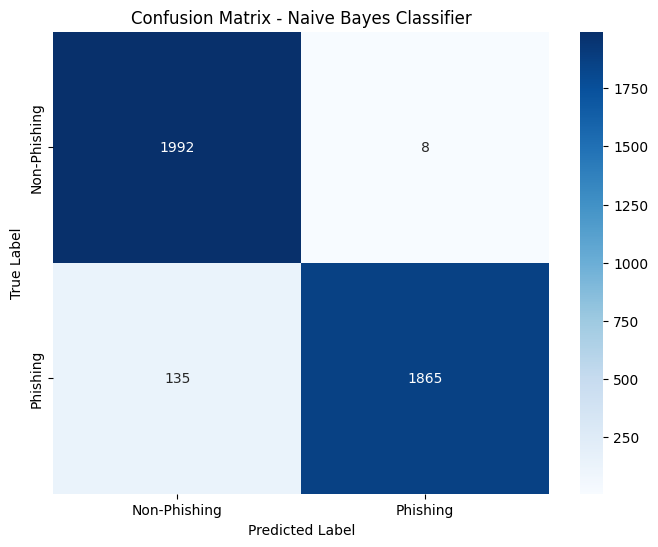

In [20]:

# Naive Bayes Classification using TF-IDF features
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for classification
X = characteristic_tfidf_matrix.toarray()  # Convert sparse matrix to dense array
y = np.array([1] * len(phishing_emails) + [0] * len(non_phishing_emails))  # 1 for phishing, 0 for non-phishing

# Check class distribution before balancing
print(f"Original dataset - Phishing: {sum(y)}, Non-phishing: {len(y) - sum(y)}")

# Apply undersampling to balance the dataset
from sklearn.utils import resample

# Combine X and y for easier manipulation
X_with_labels = np.column_stack((X, y))

# Make predictions on the test set
y_pred = nb_classifier.predict(X_with_labels[:,:-1])
y_test = y
# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"\nNaive Bayes Classifier Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Phishing', 'Phishing']))

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Phishing', 'Phishing'],
            yticklabels=['Non-Phishing', 'Phishing'])
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

